# Distance function in 2D (Linear advection 2D)

In [1]:
import turtle
import random

import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from keras.models import load_model

import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

# Constant and function definitions

In [18]:
#Seeds
np.random.seed(0)
tf.random.set_seed(0)

#Constants
Nd = 101 #Collocation points in the domain
Nb = 1   #Collocation points in the boundary

#Computation of non-smooth distance function d:
def d(xs, xbs):
  #xs: List of collocation points
  #xbs: List of boundary conditions
  xs, xbs = np.array(xs), np.array(xbs)
  ds = [min([np.linalg.norm(x - xb) for xb in xbs]) for x in xs]
  return ds

def custom_loss(y_actual,y_pred):
    custom_loss=(0.5) * 1 / (Nb + Nd) * (y_actual-y_pred)**2
    return custom_loss
    
def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)


## Define a star and use polygon to check points inside

In [3]:
star=[]
r = np.sqrt(0.5**2 + 0.25**2)
R = 1

num_vert = 12
start = np.pi / 6
for n in range(0,12):
  if n % 2:
    rad = r
  else:
    rad = R
  x = rad * np.cos(start + 2 * np.pi * n / num_vert)
  y = rad * np.sin(start + 2 * np.pi * n / num_vert)
  star.append([x,y])

star_poly = Polygon(star)

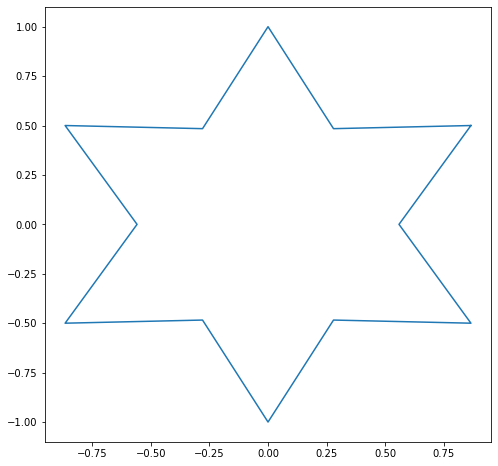

In [4]:
x,y = star_poly.exterior.xy
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(x,y)

## Generate M random points in the boundary

In [5]:
def get_random_boundary_point(polygon):
  x,y = star_poly.exterior.xy
  points = [*zip(x,y)]
  random_index = random.randint(0, len(points)-1)
  a, b = np.array(points[random_index]), np.array(points[(random_index + 1) % len(points)])
  new_random_point = a + random.random() * (b - a)
  return list(new_random_point)

In [6]:
M = 50
random_boundary_points = [get_random_boundary_point(star_poly) for _ in range(M)]

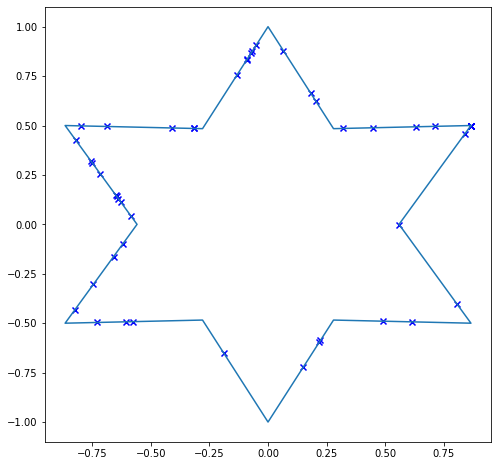

In [7]:
x,y = star_poly.exterior.xy
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(x,y)
ax.scatter(*list(zip(*random_boundary_points)), color="blue", marker='x')
plt.show()

## Generate N random points in the boundary (Satisfying inflow condition)

In [8]:
def cross(p, q):
  p_x, p_y = p
  q_x, q_y = q
  return p_x*q_y - p_y*q_x

In [9]:
def get_random_boundary_point_inflow(polygon, cond: list):
  x, y = star_poly.exterior.xy
  points = [*zip(x,y)]
  while True:
    random_index = random.randint(0, len(points)-1)
    a, b = np.array(points[random_index]), np.array(points[(random_index + 1) % len(points)])
    dx, dy = b - a
    s_x = [dx, dy]
    n_x = [-dy, dx]
    if cross(s_x, n_x) > 0:
      n_x = [dy, -dx]
    if np.dot(n_x, cond) < 0:
      new_random_point = a + random.random() * (b - a)
      return list(new_random_point)

In [10]:
M = 50
random_boundary_points = [get_random_boundary_point_inflow(star_poly, [1, 1]) for _ in range(M)]

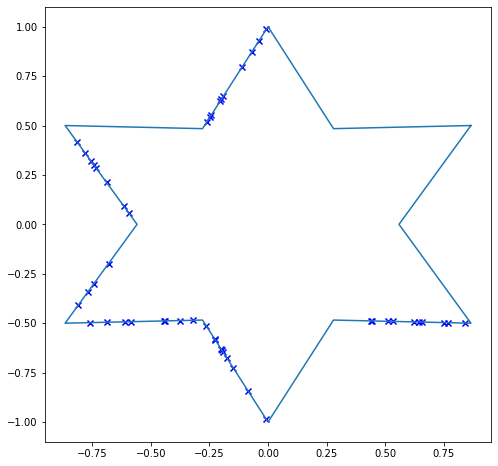

In [11]:
x,y = star_poly.exterior.xy
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(x,y)
ax.scatter(*list(zip(*random_boundary_points)), color="blue", marker='x')
plt.show()

## Generate N random points inside

In [12]:
def get_random_inside_polygon(polygon):
  minx, miny, maxx, maxy = polygon.bounds
  while True:
    p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    if polygon.contains(p):
      x, y = p.x, p.y
      return [x, y]

In [13]:
N = 500
random_inside_points = [get_random_inside_polygon(star_poly) for _ in range(N)]

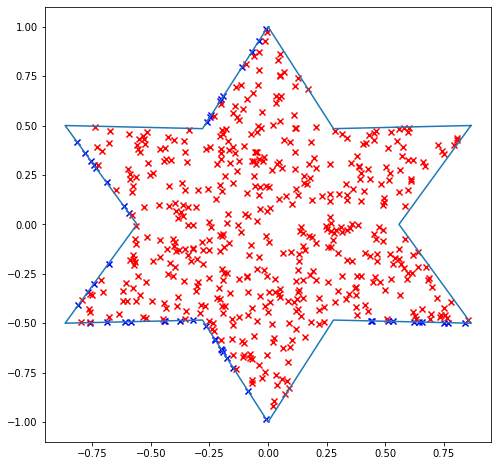

In [14]:
x,y = star_poly.exterior.xy
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(x,y)
ax.scatter(*list(zip(*random_boundary_points)), color="blue", marker='x')
ax.scatter(*list(zip(*random_inside_points)), color="red", marker='x')
plt.show()

# Model for distance function (Linear advection 2D) 

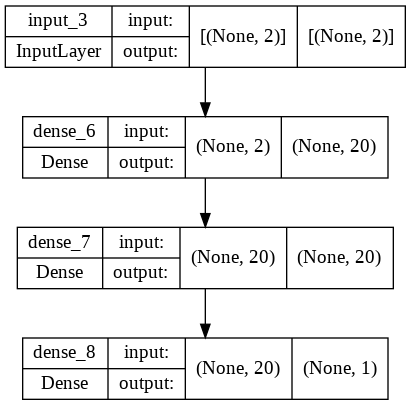

In [ ]:
#Define the model

inputs = Input(shape=(2,))
x = Dense(20, 'sigmoid', dtype='float64')(inputs)
x = Dense(20, 'sigmoid')(x)
y = Dense(1, dtype='float64')(x)
model_distance = Model(inputs=inputs, outputs=y)

optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99)
model_distance.compile(loss=custom_loss,
                optimizer=optimizer,
                metrics=['mae', 'mse'])

tf.keras.utils.plot_model(model_distance,show_shapes=True)

## Training

In [ ]:
N = 500
M = 250

random_inside_points = [get_random_inside_polygon(star_poly) for _ in range(N)]
random_boundary_points = [get_random_boundary_point_inflow(star_poly, [1, 1/2]) for _ in range(M)]

#Random set to train of train_size random points in the domain (excluding extremal points)
x_train = np.array(random_inside_points).reshape(-1, 2)
ds = d(x_train, random_boundary_points)
y_train = np.array(ds).reshape(-1, 1)

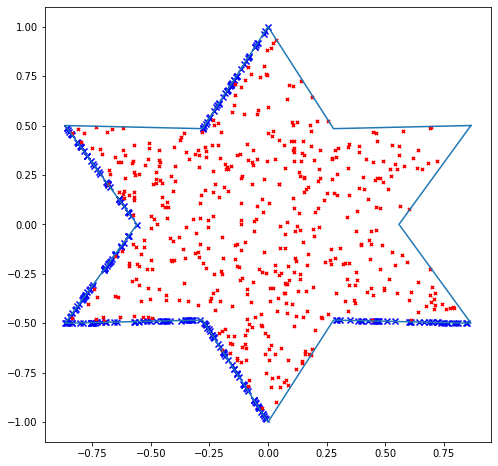

In [ ]:
x,y = star_poly.exterior.xy
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(x,y)
ax.scatter(*list(zip(*random_boundary_points)), color="blue", marker='x')
ax.scatter(*list(zip(*random_inside_points)), color="red", marker='x', s=10)
plt.show()

In [ ]:
model_distance.fit(x_train, y_train, epochs=1000, verbose=False)

## Plotting distance model

In [20]:
@np.vectorize
def distance_inside(x, y, polygon: Polygon):
  distance = model_distance.predict([[x, y]])[0][0] if polygon.contains(Point([x, y])) else np.nan
  return distance

In [21]:
# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
z = distance_inside(x, y, star_poly)

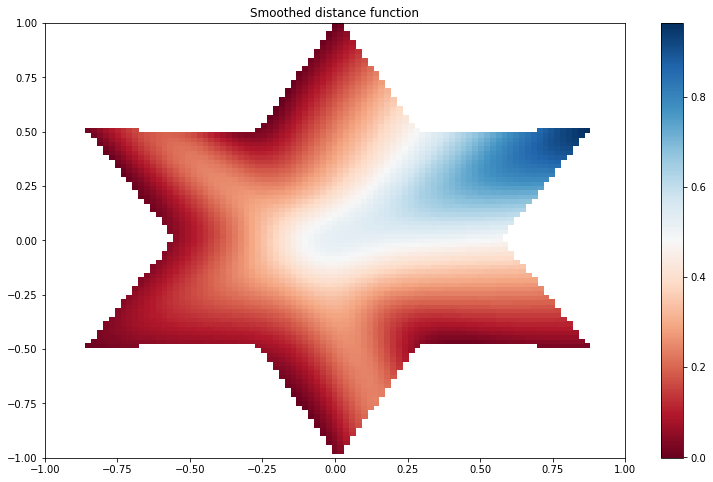

In [22]:
z_min, z_max = np.nanmin(z), np.nanmax(z)

fig, ax = plt.subplots(figsize=(13,8))

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Smoothed distance function')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

## Save model distance

In [ ]:
model_distance.save('../models/model_distance.h5')

## Load model distance

In [19]:
model_distance = load_model(
    '../models/model_distance.h5', 
    custom_objects={'custom_loss':custom_loss}
    )

# Model for the smooth extension of the boundary data ($g(x,y)$) (Linear advection 2D)

In [23]:
def u(x, y):
  return 0.5 * np.cos(np.pi * x) * np.sin(np.pi * y)

def g(x, y):
  return u(x, y)

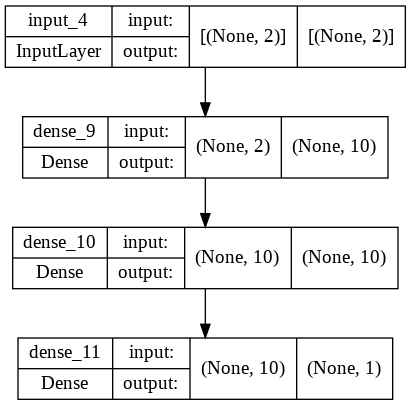

In [ ]:
#Define the model

inputs = Input(shape=(2,))
x = Dense(10, 'sigmoid', dtype='float64')(inputs)
x = Dense(10, 'sigmoid')(x)
y = Dense(1, dtype='float64')(x)
model_boundary = Model(inputs=inputs, outputs=y)

optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99)
model_boundary.compile(loss=custom_loss,
                optimizer=optimizer,
                metrics=['mae', 'mse'])

tf.keras.utils.plot_model(model_boundary,show_shapes=True)

In [ ]:
x_train = np.array(random_boundary_points).reshape(-1, 2)
y_train = np.array([g(x, y) for x, y in x_train])

model_boundary.fit(x_train, y_train, epochs=1000, verbose=False)

## Save model boundary

In [ ]:
model_boundary.save('../models/model_boundary.h5')

## Load model boundary

In [24]:
model_boundary = load_model(
    '../models/model_boundary.h5', 
    custom_objects={'custom_loss':custom_loss}
    )















# Linear advection in 2D

The equation is given by:
\begin{align*}
Lu&=a\frac{\partial u}{\partial x} + b\frac{\partial u}{\partial y}=f \;\;;\; x \in \Omega\\
u&=g \;\;;\; x \in \Gamma\\
\end{align*}

where a, b are the constant advection coefficients. The set $\Gamma \subset \partial \Omega$ is the part of the boundary where boundary conditions should
be imposed. And let $n = n(x)$ denote the outer unit normal to $\partial\Omega$ at $x \in\partial\Omega$. In such way we have that:

$$\Gamma = \{x\in\partial\Omega: (a, b) \cdot n(x) < 0\}.$$

And taking the analytic solution as follows:
$$u = \frac{1}{2}\cos(πx)\sin(πy)$$

Therefore, with $a = 1$ and $b=1/2$, we have: 
\begin{align*}
f(x) &= \frac{\pi}{2}\left(-\sin(\pi x)\sin(\pi y) + \frac{1}{2}\cos(\pi x)\cos(\pi y)\right)
\end{align*}

So, the ansatz, $\hat{u}=\hat{u}(x;w,b)$, take the form:

$$u(x) = G(x) + D(x)y^L (x; w, b) $$

In [26]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
import numpy as np
import matplotlib.pylab as plt

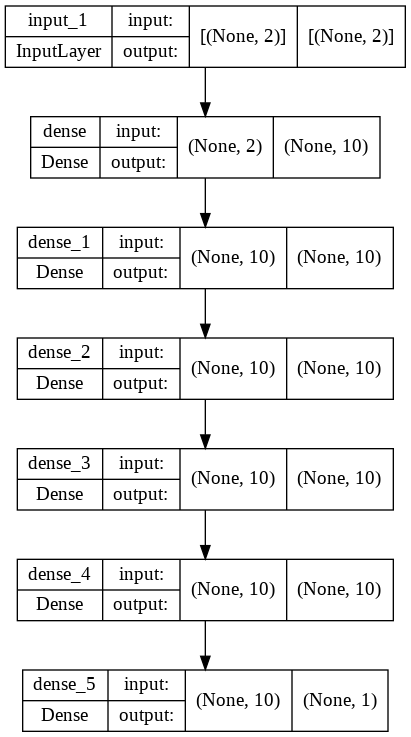

In [27]:
#Define the model

inputs = Input(shape=(2,))
x = Dense(10, 'sigmoid', dtype='float64')(inputs)
x = Dense(10, 'sigmoid')(x)
x = Dense(10, 'sigmoid')(x)
x = Dense(10, 'sigmoid')(x)
x = Dense(10, 'sigmoid')(x)
y = Dense(1, dtype='float64')(x)
model = Model(inputs=inputs, outputs=y)

tf.keras.utils.plot_model(model,show_shapes=True)

In [28]:
a, b = 1, 1/2

def u(x, y):
  return 0.5 * np.cos(np.pi*x) * np.sin(np.pi*y) 

def f(x, y, a=1, b=1/2):
  df_dx = -np.pi*np.sin(np.pi*y)*np.sin(np.pi*x)
  df_dy = np.pi*np.cos(np.pi*y)*np.cos(np.pi*x)
  return a*df_dx + b*df_dy

def D(x, y):
  points = tf.transpose([x, y])
  return model_distance(points)

def G(x, y):
  points = tf.transpose([x, y])
  return model_boundary(points)

In [29]:
num_samples = 5000

#Random set to train of train_size random points
inside_points = [get_random_inside_polygon(star_poly) for _ in range(num_samples)]

x_train = tf.constant([point[0] for point in inside_points], dtype='float64')
y_train = tf.constant([point[1] for point in inside_points], dtype='float64')

z_train = f(x_train, y_train)
# using the high level tf.data API for data handling
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(1)

In [ ]:
opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99)

x_variable = tf.Variable(x_train)
y_variable = tf.Variable(y_train) 

with tf.GradientTape() as gt_x, tf.GradientTape() as gt_y:
    gt_x.watch(x_variable)
    gt_y.watch(y_variable)
    G_xy = G(x_variable, y_variable)
dG_dx = gt_x.gradient(G_xy, x_variable)   
dG_dy = gt_y.gradient(G_xy, y_variable)  

G_pred = G(x_variable, y_variable)

with tf.GradientTape() as dt_x, tf.GradientTape() as dt_y:
    dt_x.watch(x_variable)
    dt_y.watch(y_variable)
    D_xy = D(x_variable, y_variable)
dD_dx = dt_x.gradient(D_xy, x_variable)   
dD_dy = dt_y.gradient(D_xy, y_variable)  

D_pred = D(x_variable, y_variable)

ff = tf.constant(f(x_variable, y_variable))

n_train_steps = 100000

v_loss  = np.empty((n_train_steps,0))
v_error = np.empty((n_train_steps,0))
z_pred_old = np.zeros_like(x_variable)

################################################################################

for step in range(n_train_steps):
    with tf.GradientTape() as model_tape:
        with tf.GradientTape() as z_tape_x, tf.GradientTape() as z_tape_y:
          z_tape_x.watch(x_variable)
          z_tape_y.watch(y_variable)
          z_pred = model(tf.transpose([x_variable, y_variable]))
        dz_dx = z_tape_x.gradient(z_pred, x_variable)
        dz_dy = z_tape_y.gradient(z_pred, y_variable)
        z_pred_old = z_pred.numpy()
        lu = a*(dG_dx.numpy() + dD_dx.numpy()*z_pred.numpy().reshape(-1) + D_pred.numpy()*dz_dx) + b*(dG_dy.numpy() + dD_dy.numpy()*z_pred.numpy().reshape(-1) + D_pred.numpy()*dz_dy)
        loss = tf.reduce_sum(tf.math.squared_difference(lu, ff))
        v_loss = np.append(v_loss,loss)
        
    grads = model_tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(
        (grad, var) 
        for (grad, var) in zip(grads, model.trainable_variables) 
        if grad is not None
)


    Yl = model(tf.transpose([x_variable, y_variable])).numpy().reshape(-1)
    Ds = D(x_variable, y_variable).numpy().reshape(-1)
    Gs = G(x_variable, y_variable).numpy().reshape(-1)
    u_hat = Gs+Ds*Yl
    error = np.max(np.abs(u_hat-u(x_variable, y_variable)))
    v_error = np.append(v_error, error)

In [ ]:
np.savetxt('../graficas/error_advection_2D.txt', v_error)

## Plotting advection model

In [25]:
@np.vectorize
def model_inside(x, y, polygon: Polygon):
  distance = model.predict([[x, y]])[0][0] if polygon.contains(Point([x, y])) else np.nan
  return distance

@np.vectorize
def model_distances(x, y, polygon: Polygon):
  distance_value = model_distance.predict([[x, y]])[0][0] if polygon.contains(Point([x, y])) else np.nan
  return distance_value

@np.vectorize
def model_boundaries(x, y, polygon: Polygon):
  boundary_value = model_boundary.predict([[x, y]])[0][0] if polygon.contains(Point([x, y])) else np.nan
  return boundary_value

In [ ]:
# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
z = model_inside(x, y, star_poly) * model_distances(x, y, star_poly) + model_boundaries(x, y, star_poly)

In [ ]:
z_min, z_max = np.nanmin(z), np.nanmax(z)

fig, ax = plt.subplots(figsize=(13,8))

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Smoothed function')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

## Save advection model 2D 

In [ ]:
model.save('../models/model_advection.h5')

## Load advection model 2D 

In [ ]:
model = load_model(
    '../models/model_advection.h5', 
    custom_objects={'custom_loss':custom_loss}
    )